In [2]:
# import packages
import pandas as pd
import numpy as np
import datetime as dt
import scipy.stats as sp
%load_ext google.cloud.bigquery
import pickle
from matplotlib import pyplot as plt
with open('design.pkl','rb') as f:
    set_params = pickle.load(f)
plt.rcParams.update(set_params)

In [3]:
def ft_cleaner(x):
    x = x.replace('GAS BI-FUEL', 'Other').replace('GAS', 'Other').replace('GAS DIESEL', 'Other').replace('PETROL/GAS', 'Other').replace('LPG', 'Other').replace('STEAM', 'Other').replace('LNG', 'Other').replace('OTHER', 'Other').replace('CNG', 'Other')
    x = x.replace('FUEL CELLS', 'Other')
    x = x.replace('PETROL', 'Petrol').replace('Petrol/Other', 'Petrol')
    x = x.replace('HYBRID ELECTRIC (CLEAN)', 'Hybrid').replace('HYBRID ELECTRIC', 'Hybrid').replace('ELECTRIC DIESEL', 'Hybrid')
    x = x.replace('DIESEL', 'Diesel').replace('Other Diesel', 'Diesel')
    x = x.replace('ELECTRICITY', 'Pure Electric').replace('ELECTRIC', 'Pure Electric')
    return x

In [4]:
%%bigquery van_targets --project rugged-baton-283921
SELECT make, AVG(co2Emissions) as co2Target
FROM VES_dataset.VRN_UK
WHERE ((typeApproval = 'N1') OR (typeApproval = 'N2' AND revenueWeight <= 4250))
AND monthOfFirstRegistration > '2020-12-31'
AND monthOfFirstRegistration < '2022-01-01'
AND co2Emissions > 0
GROUP BY make

Downloading: 100%|██████████| 58/58 [00:00<00:00, 67.52rows/s]


In [5]:
# car_targets.sort_values('meanCo2').plot(kind='bar', x='make', figsize=(40, 10))

In [6]:
%%bigquery df_activity --project rugged-baton-283921
SELECT 
    make, 
    COUNT(*) as totalSales,
    COUNTIF(co2Emissions > 0) as nonzevSales,
    COUNTIF(co2Emissions = 0) as zevSales,
    SUM(co2Emissions) as co2Activity

FROM VES_dataset.VRN_UK
WHERE ((typeApproval = 'N1') OR (typeApproval = 'N2' AND revenueWeight <= 4250))
AND CAST(monthOfFirstRegistration AS DATE) >= DATE_SUB(DATE_TRUNC(CURRENT_DATE(), MONTH), INTERVAL 1 YEAR)
AND CAST(monthOfFirstRegistration AS DATE) < DATE_TRUNC(CURRENT_DATE(), MONTH)
AND make IN (
    SELECT make
    FROM VES_dataset.VRN_UK
    WHERE ((typeApproval = 'N1') OR (typeApproval = 'N2' AND revenueWeight <= 4250))
    AND CAST(monthOfFirstRegistration AS DATE) >= DATE_SUB(DATE_TRUNC(CURRENT_DATE(), MONTH), INTERVAL 1 YEAR)
    AND CAST(monthOfFirstRegistration AS DATE) < DATE_TRUNC(CURRENT_DATE(), MONTH)
    -- AND total > 2500
    GROUP BY make
    HAVING COUNT(*) > 2500
)
GROUP BY make
ORDER BY totalSales ASC;

Downloading: 100%|██████████| 16/16 [00:01<00:00, 14.66rows/s]


In [7]:
dfa = df_activity.merge(van_targets, how='left', on='make')
dfa['co2Allowances'] = dfa.apply(lambda row: row.co2Target * row.nonzevSales, axis=1)
dfa['co2Compliance'] = dfa.apply(lambda row: row.co2Allowances - row.co2Activity, axis=1)

In [9]:
mandate =.1

In [10]:
def co2_to_zev(row, mandate):
    new_zev_credits = 0
    limit = mandate*.25
    limit = limit * row.totalSales
    
    if row.co2Compliance > 0:
        new_zev_credits = row.co2Compliance / 167
    
    if new_zev_credits > limit:
        new_zev_credits = limit
        
    return new_zev_credits
        
def proposed_co2_to_zev(row, mandate):
    new_zev_credits = 0
    limit = mandate*.25
    limit = limit * row.totalSales
    
    conversion_factor = row.co2Target
    
    if row.co2Compliance > 0:
        new_zev_credits = row.co2Compliance / conversion_factor
    
    if new_zev_credits > limit:
        new_zev_credits = limit
        
    return new_zev_credits


In [11]:
dfa['co2_to_mandate_allowances'] = dfa.apply(lambda row: co2_to_zev(row, mandate=mandate), axis=1)
dfa['proposed_co2_to_mandate_allowances'] = dfa.apply(lambda row: proposed_co2_to_zev(row, mandate=mandate), axis=1)


In [12]:
dfa

,make,totalSales,nonzevSales,zevSales,co2Activity,co2Target,co2Allowances,co2Compliance,co2_to_mandate_allowances,proposed_co2_to_mandate_allowances
0,MAN,2553,2468,85,602597.0,543.085422,1.340335e+06,7.377378e+05,63.825000,63.825000
1,LAND ROVER,2560,2560,0,588065.0,243.042794,6.221896e+05,3.412455e+04,64.000000,64.000000
2,RENAULT TRUCKS,2617,1531,80,1022912.0,504.247436,7.720028e+05,-2.509092e+05,0.000000,0.000000
3,FIAT,3871,3624,247,677360.0,213.268351,7.728845e+05,9.552450e+04,96.775000,96.775000
4,MAXUS,4085,1842,2237,640949.0,303.998630,5.599655e+05,-8.098352e+04,0.000000,0.000000
5,IVECO,4120,3405,5,1235970.0,558.005032,1.900007e+06,6.640371e+05,103.000000,103.000000
6,ISUZU,4204,4199,0,955370.0,268.680387,1.128189e+06,1.728189e+05,105.100000,105.100000
7,NISSAN,4385,4026,114,916959.0,230.810004,9.292411e+05,1.228208e+04,73.545373,53.212933
8,TOYOTA,12671,11654,1015,2455178.0,220.192343,2.566122e+06,1.109436e+05,316.775000,316.775000
9,PEUGEOT,16741,13740,2986,2651280.0,183.141787,2.516368e+06,-1.349118e+05,0.000000,0.000000


In [16]:
mandate = .1
dfa['ZEVMallowances'] = dfa.apply(lambda row: (1-mandate) * row.totalSales, axis=1)
dfa['ZEV Surplus'] = dfa.apply(lambda row: row.ZEVMallowances - row.nonzevSales, axis=1)
dfa['ZEV Surplus after CO2'] = dfa.apply(lambda row: row['ZEV Surplus'] + row.co2_to_mandate_allowances, axis=1)
dfa['ZEV Surplus after CO2 - Proposed'] = dfa.apply(lambda row: row['ZEV Surplus'] + row.proposed_co2_to_mandate_allowances, axis=1)

In [17]:
(1 - (mandate * .25)) * 135525

132136.875

In [18]:
dfa[dfa.make == 'VOLKSWAGEN']

,make,totalSales,nonzevSales,zevSales,co2Activity,co2Target,co2Allowances,co2Compliance,co2_to_mandate_allowances,proposed_co2_to_mandate_allowances,ZEVMallowances,ZEV Surplus,ZEV Surplus after CO2,ZEV Surplus after CO2 - Proposed
14,VOLKSWAGEN,26939,26622,317,5242270.0,201.452708,5.363074e+06,120803.985593,673.475,599.664244,24245.1,-2376.9,-1703.425,-1777.235756


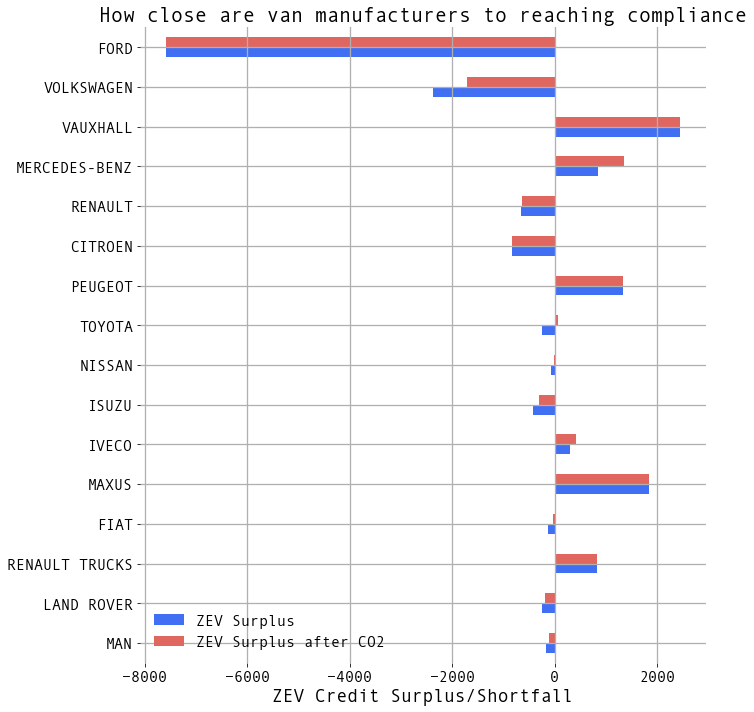

In [20]:
fig, ax = plt.subplots()

dfa.plot(x='make', y=[
    'ZEV Surplus', 
    'ZEV Surplus after CO2', 
    # 'ZEV Surplus after CO2 - Proposed'
], kind='barh', ax=ax, figsize=(10, 10))
ax.set_xlabel('ZEV Credit Surplus/Shortfall')
ax.set_ylabel('')

ax.set_title('How close are van manufacturers to reaching compliance')

plt.savefig('plots/van_top_20_last_12_months.png', transparent=False, bbox_inches='tight', dpi=300)
plt.show()

In [21]:
dfa['CO2 Performance'] = dfa.co2Activity / dfa.nonzevSales

In [22]:
dfa_sel = dfa[[
    'make',
    'totalSales',
    'nonzevSales',
    'zevSales',
    'co2Target',
    'CO2 Performance',
    'ZEVMallowances',
    'ZEV Surplus',
    'ZEV Surplus after CO2'
]].rename(columns={
    'make': 'Make',
    'totalSales': 'Total Sales',
    'co2Target': 'CO2 Target',
    'nonzevSales': 'Non-ZEV Sales',
    'zevSales': 'ZEV Sales',
    'ZEVMallowances': 'Allocated allowances',
    'ZEV Surplus': 'Allowance Surplus',
    'ZEV Surplus after CO2': 'Allowance Surplus (after CO2 transfers)'
})

# dfa_sel['Mean CO2'] = 
dfa_sel = round(dfa_sel, ndigits=2)

dfa_sel = dfa_sel.sort_values('Total Sales', ascending=False)

In [23]:
dfa_sel.to_csv('van_ZEV_compliance_tracker.csv')

# Rolling Performance

In [24]:
%%bigquery df_act --project rugged-baton-283921
SELECT 
    VES.make,
    VES.monthOfFirstRegistration,
    COUNT(*) as totalSales,
    COUNTIF(VES.co2Emissions > 0) as nonzevSales,
    COUNTIF(VES.co2Emissions = 0) as zevSales,
    SUM(VES.co2Emissions) as co2Activity

FROM VES_dataset.VRN_UK VES
WHERE ((typeApproval = 'N1') OR (typeApproval = 'N2' AND revenueWeight <= 4250))
AND CAST(monthOfFirstRegistration AS DATE) > '2020-03-31'
AND CAST(monthOfFirstRegistration AS DATE) < DATE_TRUNC(CURRENT_DATE(), MONTH)
# AND make IN (
#     SELECT make
#     FROM VES_dataset.VRN_UK
#     WHERE typeApproval = 'M1'
#     AND monthOfFirstRegistration > '2020-03-31'
#     AND monthOfFirstRegistration < '2023-04-01'
#     GROUP BY make
#     ORDER BY COUNT(*) DESC
#     LIMIT 20
    
# )

# Volume limit
AND make IN (
    SELECT make
    FROM VES_dataset.VRN_UK
    WHERE ((typeApproval = 'N1') OR (typeApproval = 'N2' AND revenueWeight <= 4250))
    AND CAST(monthOfFirstRegistration AS DATE) >= DATE_SUB(DATE_TRUNC(CURRENT_DATE(), MONTH), INTERVAL 1 YEAR)
    AND CAST(monthOfFirstRegistration AS DATE) < DATE_TRUNC(CURRENT_DATE(), MONTH)
    -- AND total > 2500
    GROUP BY make
    HAVING COUNT(*) > 2500
)



GROUP BY make, monthofFirstRegistration
ORDER BY totalSales ASC;

Downloading: 100%|██████████| 571/571 [00:00<00:00, 666.01rows/s]


In [25]:
# If we want to filter out all but the top five/ten/twenty makes, we can use this
top_makes = df_act.groupby('make').sum().sort_values('totalSales', ascending=False).index.tolist()[:10]

In [26]:
# Make a copy to edit
df = df_act.copy()#.merge(car_targets, how='left', on='make')

In [27]:
df.head()

,make,monthOfFirstRegistration,totalSales,nonzevSales,zevSales,co2Activity
0,LAND ROVER,2020-04-01 00:00:00+00:00,3,3,0,606.0
1,MAXUS,2020-11-01 00:00:00+00:00,17,16,1,3488.0
2,LAND ROVER,2020-05-01 00:00:00+00:00,18,18,0,3632.0
3,LAND ROVER,2020-08-01 00:00:00+00:00,19,19,0,3842.0
4,MAXUS,2020-10-01 00:00:00+00:00,19,17,2,3706.0


In [28]:
# This turns our numbers into 12 month rolling totals/averages

dfs = []
makes = df.make.unique().tolist()

for make in makes:
    temp_df = df[df.make == make].set_index('monthOfFirstRegistration').sort_index().rolling(12).sum()
    temp_df = temp_df.reset_index().dropna()
    temp_df['make'] = make
    dfs.append(temp_df)
    
df = pd.concat(dfs)

In [31]:
# This gives us the targets for CO2 performance
df = df.reset_index().merge(van_targets, how='left', on='make')

In [32]:
df['co2Allowances'] = df.apply(lambda row: row.co2Target * row.nonzevSales, axis=1)
df['co2Compliance'] = df.apply(lambda row: row.co2Allowances - row.co2Activity, axis=1)
df['co2_to_mandate_allowances'] = df.apply(lambda row: co2_to_zev(row, mandate=.22), axis=1)
# df['proposed_co2_to_mandate_allowances'] = df.apply(lambda row: proposed_co2_to_zev(row,), axis=1)

In [33]:
mandate = .1
df['ZEVMallowances'] = df.apply(lambda row: (1-mandate) * row.totalSales, axis=1)
df['ZEV Surplus'] = df.apply(lambda row: row.ZEVMallowances - row.nonzevSales, axis=1)
df['ZEV Surplus after CO2'] = df.apply(lambda row: row['ZEV Surplus'] + row.co2_to_mandate_allowances, axis=1)
# df['ZEV Surplus after CO2 - Proposed'] = df.apply(lambda row: row['ZEV Surplus'] + row.proposed_co2_to_mandate_allowances, axis=1)

In [34]:
# Are there any manufacturers failing to make Co2 compliance but with surplus ZEV credits, who would need to transfer ZEV credits into the regime 
# We assume that manufacturers would rather transfer from CO2 than purchase CO2 allowances. 
# df[(df['ZEV Surplus'] > 0) & (df.co2Compliance < 0)]

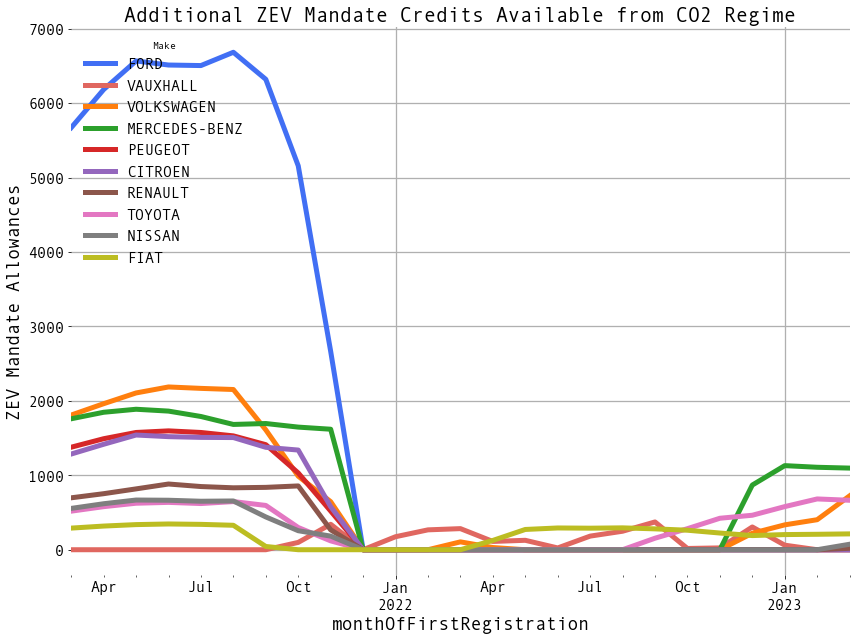

In [35]:
fig, ax = plt.subplots()

df.pivot(index='monthOfFirstRegistration', columns='make', values='co2_to_mandate_allowances')[top_makes].plot(ax=ax)
ax.set_ylabel('ZEV Mandate Allowances')
ax.legend(title='Make', loc='upper left')
ax.set_title('Additional ZEV Mandate Credits Available from CO2 Regime')

plt.show()

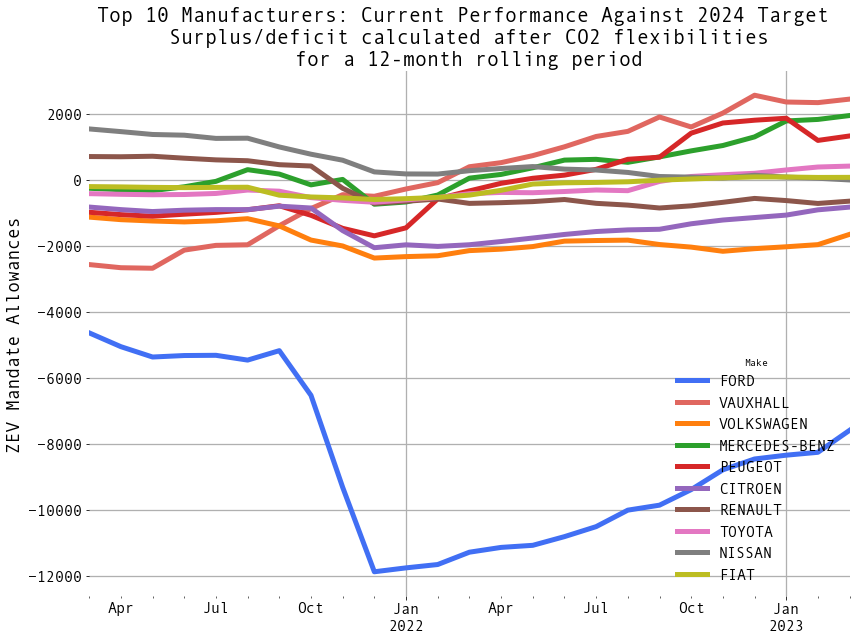

In [36]:
fig, ax = plt.subplots()

df.pivot(index='monthOfFirstRegistration', columns='make', values='ZEV Surplus after CO2')[top_makes].plot(ax=ax)
ax.set_ylabel('ZEV Mandate Allowances')
ax.set_xlabel('')
ax.set_title('Top 10 Manufacturers: Current Performance Against 2024 Target \n Surplus/deficit calculated after CO2 flexibilities \nfor a 12-month rolling period')
ax.legend(title='Make', loc='lower right')

# plt.savefig('plots/top_10_manufacturers_zevm.png', transparent=False, bbox_inches='tight', dpi=300)
plt.show()

In [37]:
dfa

,make,totalSales,nonzevSales,zevSales,co2Activity,co2Target,co2Allowances,co2Compliance,co2_to_mandate_allowances,proposed_co2_to_mandate_allowances,ZEVMallowances,ZEV Surplus,ZEV Surplus after CO2,ZEV Surplus after CO2 - Proposed,CO2 Performance
0,MAN,2553,2468,85,602597.0,543.085422,1.340335e+06,7.377378e+05,63.825000,63.825000,2297.7,-170.3,-106.475000,-106.475000,244.164100
1,LAND ROVER,2560,2560,0,588065.0,243.042794,6.221896e+05,3.412455e+04,64.000000,64.000000,2304.0,-256.0,-192.000000,-192.000000,229.712891
2,RENAULT TRUCKS,2617,1531,80,1022912.0,504.247436,7.720028e+05,-2.509092e+05,0.000000,0.000000,2355.3,824.3,824.300000,824.300000,668.133246
3,FIAT,3871,3624,247,677360.0,213.268351,7.728845e+05,9.552450e+04,96.775000,96.775000,3483.9,-140.1,-43.325000,-43.325000,186.909492
4,MAXUS,4085,1842,2237,640949.0,303.998630,5.599655e+05,-8.098352e+04,0.000000,0.000000,3676.5,1834.5,1834.500000,1834.500000,347.963626
5,IVECO,4120,3405,5,1235970.0,558.005032,1.900007e+06,6.640371e+05,103.000000,103.000000,3708.0,303.0,406.000000,406.000000,362.986784
6,ISUZU,4204,4199,0,955370.0,268.680387,1.128189e+06,1.728189e+05,105.100000,105.100000,3783.6,-415.4,-310.300000,-310.300000,227.523220
7,NISSAN,4385,4026,114,916959.0,230.810004,9.292411e+05,1.228208e+04,73.545373,53.212933,3946.5,-79.5,-5.954627,-26.287067,227.759314
8,TOYOTA,12671,11654,1015,2455178.0,220.192343,2.566122e+06,1.109436e+05,316.775000,316.775000,11403.9,-250.1,66.675000,66.675000,210.672559
9,PEUGEOT,16741,13740,2986,2651280.0,183.141787,2.516368e+06,-1.349118e+05,0.000000,0.000000,15066.9,1326.9,1326.900000,1326.900000,192.960699


<AxesSubplot:xlabel='monthOfFirstRegistration'>

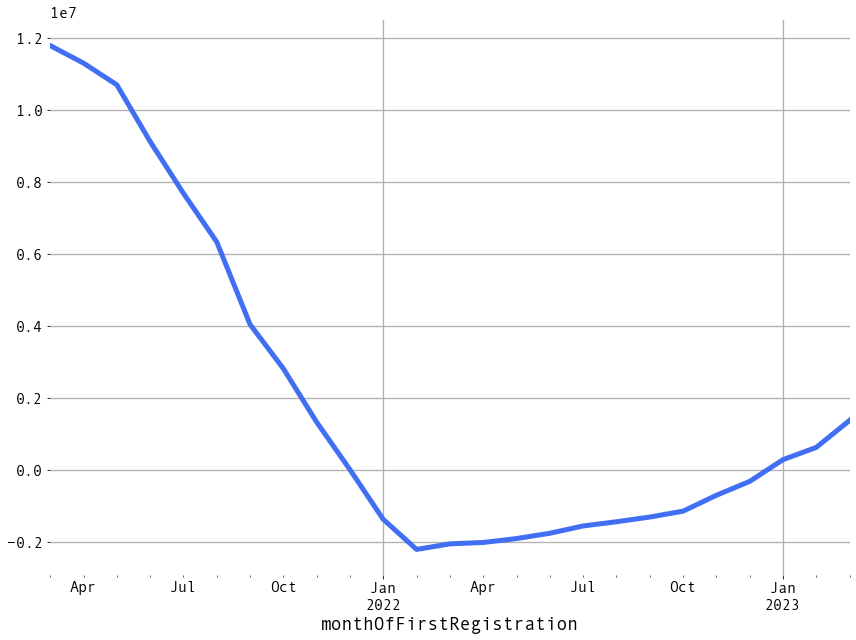

In [38]:
df.groupby(['monthOfFirstRegistration']).sum().co2Compliance.plot()

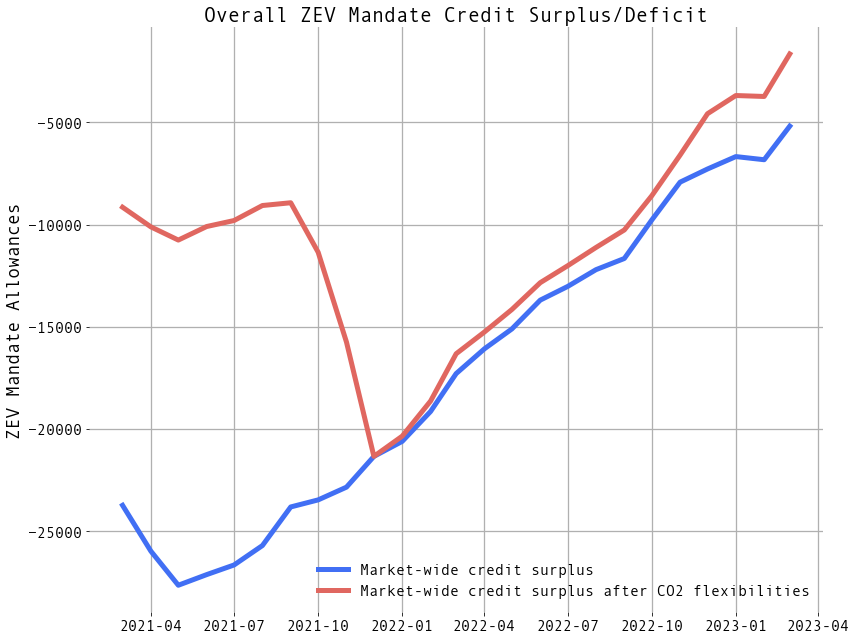

In [45]:
fig, ax = plt.subplots()

ax.plot(df.groupby('monthOfFirstRegistration').sum()['ZEV Surplus'], label='Market-wide credit surplus')
ax.plot(df.groupby('monthOfFirstRegistration').sum()['ZEV Surplus after CO2'], label='Market-wide credit surplus after CO2 flexibilities')
# ax.plot(df.groupby('monthOfFirstRegistration').sum()['ZEV Surplus after CO2 - Proposed'], label='Proposed Market-wide credit surplus after CO2 flexibilities')
ax.set_ylabel('ZEV Mandate Allowances')

ax.legend(loc='lower right')
ax.set_title('Overall ZEV Mandate Credit Surplus/Deficit')

plt.savefig('plots/van_aggregate_demand_credits.png', transparent=False, bbox_inches='tight', dpi=300)
plt.show()

In [41]:
df['meanCo2'] = df.apply(lambda row: row.co2Activity / row.nonzevSales if row.nonzevSales >0 else np.nan , axis=1)

In [42]:
van_targets[van_targets.make.isin(top_makes)]

,make,co2Target
0,FIAT,213.268351
1,VAUXHALL,190.109719
2,VOLKSWAGEN,201.452708
9,CITROEN,180.894392
10,PEUGEOT,183.141787
15,FORD,203.274374
16,RENAULT,215.649407
17,NISSAN,230.810004
40,MERCEDES-BENZ,342.812470
48,TOYOTA,220.192343


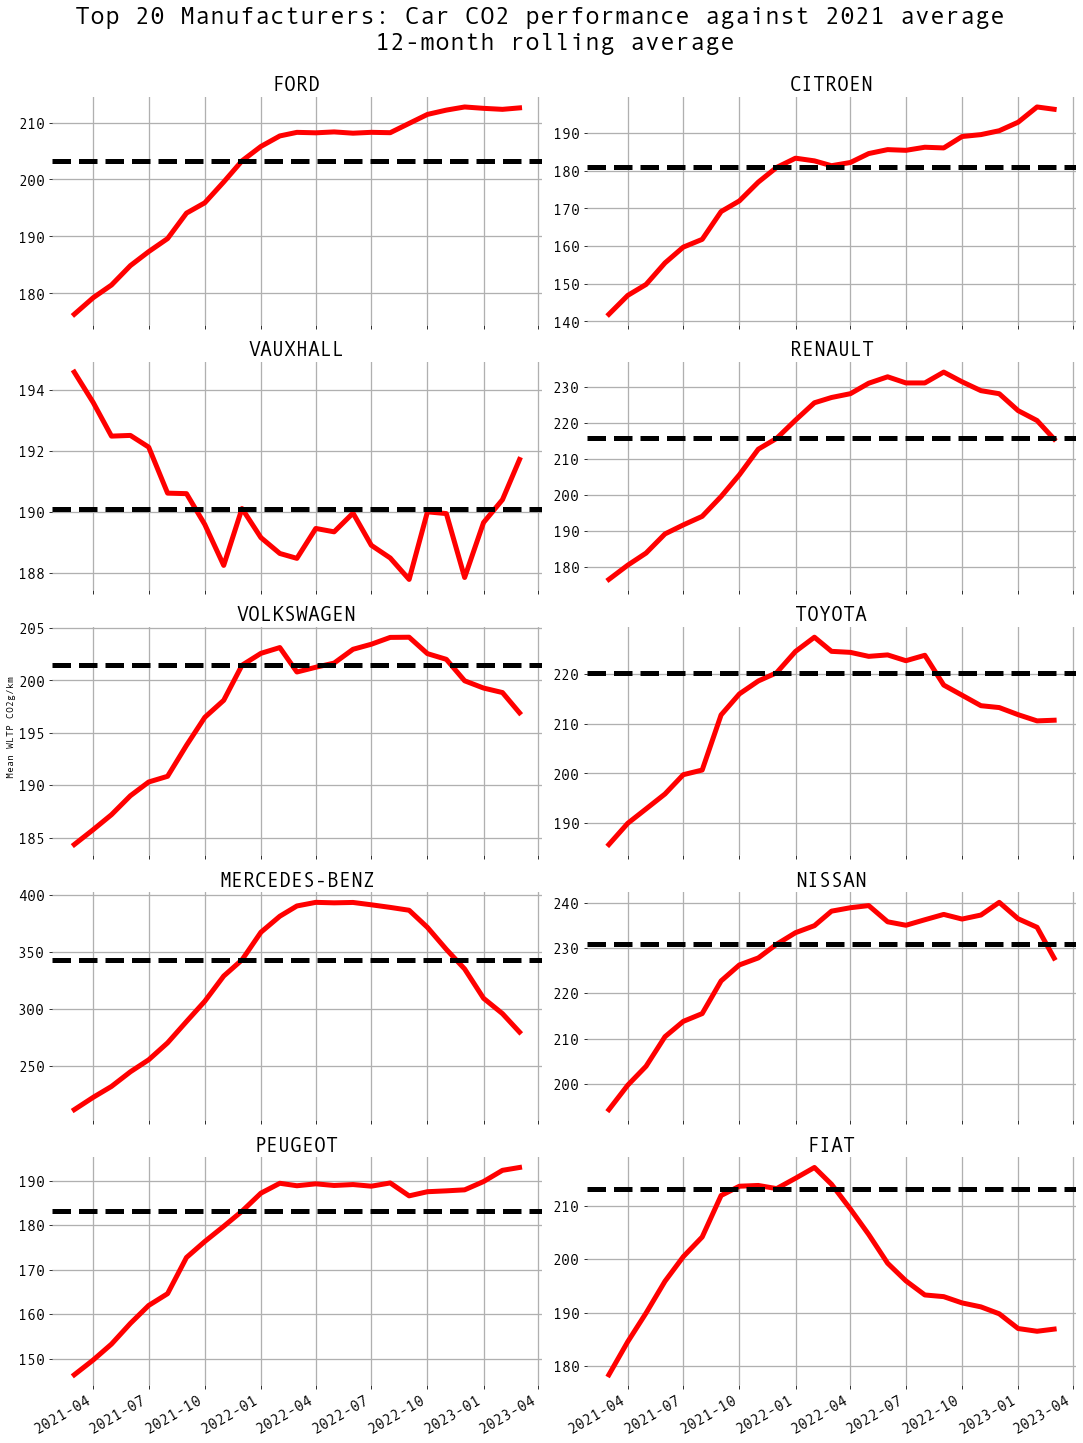

In [44]:
fig, ax = plt.subplots(5, 2, figsize=(15, 20))

# # df.pivot(index='monthOfFirstRegistration', columns='make', values='meanCo2')[top_makes].plot(ax=ax)
# # ax.axhline(car_targets[car_targets.make.isin(top_makes)])
# # ax.set_xlabel('')
# # ax.legend(title='Make', loc='lower right')

plt_df = df.pivot(index='monthOfFirstRegistration', columns='make', values='meanCo2')[top_makes]



for e, make in enumerate(top_makes[:5]):
    ax[e, 0].plot(plt_df[make], c='red')
    ax[e, 0].axhline(van_targets[van_targets.make == make].co2Target.values, c='black', linestyle='--')
    ax[e, 0].set_title(make)
    ax[e, 0].figure.autofmt_xdate()
    # ax[e, 0].set_ylabel('Mean WLPT CO2g/km')
    
for e, make in enumerate(top_makes[5:]):
    ax[e, 1].plot(plt_df[make], c='red')
    ax[e, 1].axhline(van_targets[van_targets.make == make].co2Target.values, c='black', label='2021 Baseline Target', linestyle='--')
    ax[e, 1].set_title(make)
    ax[e, 1].figure.autofmt_xdate()
    # ax[e, 1].set_ylabel('Mean WLPT CO2g/km')
    

fig.text(0.0, 0.5, 'Mean WLTP CO2g/km', va='center', rotation='vertical', fontsize=10)
fig.suptitle('Top 20 Manufacturers: Car CO2 performance against 2021 average \n 12-month rolling average', y=1, fontsize=25)
fig.tight_layout()
# plt.show()

plt.savefig('plots/van_co2.png', transparent=False, bbox_inches='tight', dpi=300)

# ax[0, 0]